In [1]:
import os
import random
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib.patches import Ellipse
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Data Loading and Exploration
def load_data(file_path, digits=['digit_1','digit_2','digit_3']):
    """Load rotated MNIST data from HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        # Get all keys
        print("Available keys:", list(f.keys()))
        
        # Load data for each digit
        data = {}
        for key in f.keys():
            if key.startswith('digit_') and key in digits:
                data[key] = np.array(f[key])
        
        return data

def plot_sample_digits(data):
    """Plot sample digits with different rotations."""
    n_digits = len(data)
    fig, axes = plt.subplots(n_digits, 4, figsize=(15, 3 * n_digits))
    if n_digits == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle("Sample Digits with Different Rotations", fontsize=16)
    
    for i, digit_key in enumerate(sorted(data.keys())):
        # Select a random sample
        sample_idx = np.random.randint(0, data[digit_key].shape[0])
        
        # Plot 4 different rotations
        for j in range(4):
            rotation_idx = j * 3  # 0, 3, 6, 9 (0, 90, 180, 270 degrees)
            img = data[digit_key][sample_idx, rotation_idx, 0]
            
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f"{digit_key}, Rotation: {rotation_idx*30}°")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# 2. Data Preprocessing
def preprocess_data(data, test_size=0.2, seed=42):
    """
    Preprocess data, combining all rotations and splitting into train/test.
    
    Args:
        data: Dictionary containing digit data
        test_size: Fraction of data to use for testing
        seed: Random seed for reproducibility
    
    Returns:
        X_train, X_test, y_train, y_test: Processed data arrays and labels
    """
    X_all_list = []
    y_all_list = []
    
    for digit_idx, key in enumerate(sorted(data.keys())):
        digit_data = data[key]
        n_samples, n_rotations, _, h, w = digit_data.shape
        
        # Extract data for all rotations
        for rot_idx in range(n_rotations):
            X = digit_data[:, rot_idx, 0]  # Shape: (n_samples, h, w)
            X_all_list.append(X)
            
            # Create labels: (digit, rotation)
            y = np.ones((X.shape[0], 2), dtype=np.int32)
            y[:, 0] = digit_idx + 1  # Digit number (1-indexed)
            y[:, 1] = rot_idx  # Rotation index
            y_all_list.append(y)
    
    # Concatenate all data
    X_all = np.concatenate(X_all_list, axis=0)
    y_all = np.concatenate(y_all_list, axis=0)
    
    # Perform train-test split with stratification by digit
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=seed, 
        shuffle=True, stratify=y_all[:,0]
    )    
    
    # Reshape for PyTorch CNN (batch, channels, height, width)
    X_train = X_train.reshape(-1, 1, h, w)
    X_test = X_test.reshape(-1, 1, h, w)
    
    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / np.max(X_train)
    X_test = X_test.astype('float32') / np.max(X_train)
    
    return X_train, X_test, y_train, y_test

def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=128):
    """Create PyTorch DataLoaders from numpy arrays"""
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
    )
    
    return train_loader, test_loader

# 3. VAE Model Implementation
class VAEBase(nn.Module):
    """Base class for all VAE architectures"""
    def __init__(self, latent_dim):
        super(VAEBase, self).__init__()
        self.latent_dim = latent_dim
        
    def encode(self, x):
        """Map x to the parameters of the latent distribution"""
        raise NotImplementedError("Subclasses must implement encode()")
    
    def decode(self, z):
        """Map latent samples to the reconstructed input"""
        raise NotImplementedError("Subclasses must implement decode()")
    
    def reparameterize(self, mu, log_var):
        """Reparameterization trick for sampling from latent space"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        """Full forward pass through the VAE"""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var, z
    
    def loss_function(self, recon_x, x, mu, log_var, kld_weight=1.0):
        """VAE loss function: reconstruction + KL divergence losses"""
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kld_weight * kld_loss, recon_loss, kld_loss
    
    @torch.no_grad()
    def sample(self, n_samples):
        """Sample from the latent space and decode"""
        z = torch.randn(n_samples, self.latent_dim).to(device)
        samples = self.decode(z)
        return samples
    
    @torch.no_grad()
    def reconstruct(self, x):
        """Reconstruct input by encoding and then decoding"""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon

class ConvVAE(VAEBase):
    """Convolutional VAE for MNIST"""
    def __init__(self, latent_dim=2):
        super(ConvVAE, self).__init__(latent_dim)
        
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_log_var = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = self.flatten(h)
        return self.fc_mu(h), self.fc_log_var(h)
    
    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder_conv(h)

class DeepVAE(VAEBase):
    """Deeper VAE with more conv layers"""
    def __init__(self, latent_dim=2):
        super(DeepVAE, self).__init__(latent_dim)
        
        # Encoder with more layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        self.fc_hidden = nn.Linear(128 * 7 * 7, 256)
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        
        # Decoder with more layers
        self.decoder_input = nn.Linear(latent_dim, 256)
        self.decoder_hidden = nn.Linear(256, 128 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = self.flatten(h)
        h = self.relu(self.fc_hidden(h))
        return self.fc_mu(h), self.fc_log_var(h)
    
    def decode(self, z):
        h = self.relu(self.decoder_input(z))
        h = self.relu(self.decoder_hidden(h))
        h = h.view(-1, 128, 7, 7)
        return self.decoder_conv(h)


# Factory function to create VAE models
def create_vae_model(model_type, latent_dim):
    if model_type == "conv":
        return ConvVAE(latent_dim).to(device)
    elif model_type == "deep":
        return DeepVAE(latent_dim).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# 4. Model Training
def train_vae(model, train_loader, val_loader, optimizer, epochs, kld_weight=1.0, patience=5):
    """Train the VAE model"""
    model.train()
    train_history = {
        "loss": [],
        "recon_loss": [],
        "kld_loss": [],
        "val_loss": [],
        "val_recon_loss": [],
        "val_kld_loss": []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        train_loss = 0
        train_recon_loss = 0
        train_kld_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var, _ = model(data)
            loss, recon, kld = model.loss_function(recon_batch, data, mu, log_var, kld_weight)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_recon_loss += recon.item()
            train_kld_loss += kld.item()
            
        # Validation
        val_loss, val_recon_loss, val_kld_loss = validate_vae(model, val_loader, kld_weight)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
        
        # Record metrics
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_recon_loss = train_recon_loss / len(train_loader.dataset)
        avg_train_kld_loss = train_kld_loss / len(train_loader.dataset)
        
        train_history["loss"].append(avg_train_loss)
        train_history["recon_loss"].append(avg_train_recon_loss)
        train_history["kld_loss"].append(avg_train_kld_loss)
        train_history["val_loss"].append(val_loss)
        train_history["val_recon_loss"].append(val_recon_loss)
        train_history["val_kld_loss"].append(val_kld_loss)
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Make sure we use the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_history

@torch.no_grad()
def validate_vae(model, dataloader, kld_weight=1.0):
    """Validate the VAE model"""
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kld_loss = 0
    
    for data, _ in dataloader:
        data = data.to(device)
        recon_batch, mu, log_var, _ = model(data)
        loss, recon, kld = model.loss_function(recon_batch, data, mu, log_var, kld_weight)
        
        val_loss += loss.item()
        val_recon_loss += recon.item()
        val_kld_loss += kld.item()
    
    return (
        val_loss / len(dataloader.dataset),
        val_recon_loss / len(dataloader.dataset),
        val_kld_loss / len(dataloader.dataset)
    )

def plot_training_history(history):
    """Plot training and validation loss."""
    plt.figure(figsize=(12, 5))
    
    # Plot total loss
    plt.subplot(1, 3, 1)
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history["recon_loss"], label="Training")
    plt.plot(history["val_recon_loss"], label="Validation")
    plt.title("Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot KL loss
    plt.subplot(1, 3, 3)
    plt.plot(history["kld_loss"], label="Training")
    plt.plot(history["val_kld_loss"], label="Validation")
    plt.title("KL Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 5. Latent Space Visualization
@torch.no_grad()
def encode_data(model, dataloader):
    """Encode data into latent space"""
    model.eval()
    z_means = []
    z_log_vars = []
    labels_list = []
    
    for data, labels in dataloader:
        data = data.to(device)
        mu, log_var = model.encode(data)
        z_means.append(mu.cpu().numpy())
        z_log_vars.append(log_var.cpu().numpy())
        labels_list.append(labels.numpy())
    
    z_means = np.vstack(z_means)
    z_log_vars = np.vstack(z_log_vars)
    labels = np.vstack(labels_list)
    
    return z_means, z_log_vars, labels

def encode_and_plot_latent_space(model, dataloader, title="Latent Space Visualization"):
    """
    Encode data into latent space and visualize it.
    """
    # Encode the data
    z_mean, z_log_var, labels = encode_data(model, dataloader)
    
    # Project data to 2D if needed
    if z_mean.shape[1] > 2:
        z_mean = PCA(n_components=2).fit_transform(z_mean)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'z1': z_mean[:, 0],
        'z2': z_mean[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    # Map rotation indices to degrees
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    # Plot the latent space
    plt.figure(figsize=(12, 10))
    
    # Create a custom colormap for different digits
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Plot each digit with different markers for different rotations
    for digit in sorted(df['digit'].unique()):
        digit_idx = int(digit) - 1  # Convert to 0-based index
        if digit_idx < len(colors):
            color = colors[digit_idx]
        else:
            color = None  # Let matplotlib choose
            
        digit_data = df[df['digit'] == digit]
        
        # Scatter plot
        scatter = plt.scatter(
            digit_data['z1'], 
            digit_data['z2'], 
            c=digit_data['rotation_degrees'], 
            marker=f"${int(digit)}$",  # Use digit as marker
            alpha=0.7,
            s=100,  # Marker size
            cmap='viridis',
            label=f"Digit {int(digit)}"
        )
    
    # Add a colorbar for rotation
    cbar = plt.colorbar()
    cbar.set_label('Rotation (degrees)')
    
    plt.title(title, fontsize=16)
    plt.xlabel("Latent Dimension 1", fontsize=12)
    plt.ylabel("Latent Dimension 2", fontsize=12)
    plt.legend(title="Digit")
    plt.grid(alpha=0.3)
    plt.show()
    
    return z_mean, labels

def plot_rotation_trajectories(model, dataloader):
    """
    Plot the trajectories of the same digit with different rotations in latent space.
    """
    z_mean, z_log_var, labels = encode_data(model, dataloader)
    z_var = np.exp(z_log_var)
    
    # Project to 2D if needed
    if z_mean.shape[1] > 2:
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z_mean)
        
        # Project variance to PCA space
        z_var_pca = np.dot(z_var, pca.components_.T)[:, :2]
    else:
        z_pca = z_mean
        z_var_pca = z_var
    
    digit_labels = labels[:, 0]
    rotation_labels = labels[:, 1]
    
    df = pd.DataFrame({
        'z1': z_pca[:, 0],
        'z2': z_pca[:, 1],
        'var1': z_var_pca[:, 0],
        'var2': z_var_pca[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    grouped = df.groupby(['digit', 'rotation_degrees']).agg({
        'z1': 'mean',
        'z2': 'mean',
        'var1': 'mean',
        'var2': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 10))
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, digit in enumerate(sorted(df['digit'].unique())):
        digit_data = grouped[grouped['digit'] == digit]
        if len(digit_data) == 0:
            continue
            
        if i < len(colors):
            color = colors[i]
        else:
            color = None  # Let matplotlib choose
            
        digit_data = digit_data.sort_values('rotation_degrees')
        
        mean_z1, mean_z2 = digit_data['z1'], digit_data['z2']
        var_z1, var_z2 = np.abs(digit_data['var1']), np.abs(digit_data['var2'])
        
        plt.plot(mean_z1, mean_z2, 'o-', color=color, 
                linewidth=2, markersize=8, label=f"Digit {int(digit)}")
        
        for j in range(len(mean_z1)):
            ellipse = Ellipse(
                (mean_z1.iloc[j], mean_z2.iloc[j]),
                width=2 * np.sqrt(var_z1.iloc[j]),
                height=2 * np.sqrt(var_z2.iloc[j]),
                edgecolor=color,
                facecolor='none',
                alpha=0.5
            )
            plt.gca().add_patch(ellipse)
            plt.text(mean_z1.iloc[j], mean_z2.iloc[j], 
                    f"{int(digit_data.iloc[j]['rotation_degrees'])}°", 
                    fontsize=9, ha='center', va='bottom', 
                    color=color)
    
    plt.title("Latent Space Trajectories with Model Variance", fontsize=16)
    plt.xlabel("Latent Dimension 1", fontsize=12)
    plt.ylabel("Latent Dimension 2", fontsize=12)
    plt.legend(title="Digit")
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.show()

# 6. Reconstruction Visualization
@torch.no_grad()
def plot_reconstructions(model, dataloader, n_samples=5):
    """
    Plot original images and their reconstructions.
    
    Args:
        model: Trained VAE model
        dataloader: DataLoader for the data
        n_samples: Number of samples to plot per digit
    """
    model.eval()
    
    # Get a batch of data
    data_list = []
    labels_list = []
    
    for data, labels in dataloader:
        data_list.append(data)
        labels_list.append(labels)
        if len(data_list) * dataloader.batch_size >= n_samples * 10:  # Collect enough samples
            break
    
    data = torch.cat(data_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    # Convert to numpy for easier handling
    data_np = data.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Get reconstructions
    data_device = data.to(device)
    reconstructions = model.reconstruct(data_device).cpu().numpy()
    
    # Create a figure
    available_digits = sorted(np.unique(labels_np[:, 0]))
    n_digits = len(available_digits)
    
    fig, axes = plt.subplots(n_digits, n_samples * 2, figsize=(n_samples * 4, 3 * n_digits))
    if n_digits == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle("Original Images vs. Reconstructions", fontsize=16)
    
    # Plot originals and reconstructions for each digit
    for digit_idx, digit in enumerate(available_digits):
        # Find samples of this digit
        indices = np.where(labels_np[:, 0] == digit)[0]
        selected_indices = np.random.choice(indices, min(n_samples, len(indices)), replace=False)
        
        for i, idx in enumerate(selected_indices):
            # Original image
            axes[digit_idx, i*2].imshow(data_np[idx, 0], cmap='gray')
            axes[digit_idx, i*2].set_title(f"Original\nDigit {int(digit)}, {labels_np[idx, 1]*30}°")
            axes[digit_idx, i*2].axis('off')
            
            # Reconstruction
            axes[digit_idx, i*2+1].imshow(reconstructions[idx, 0], cmap='gray')
            axes[digit_idx, i*2+1].set_title(f"Reconstruction\nDigit {int(digit)}, {labels_np[idx, 1]*30}°")
            axes[digit_idx, i*2+1].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

@torch.no_grad()
def generate_from_latent_space(model, n_grid=15):
    """
    Generate images by sampling from the latent space.
    
    Args:
        model: Trained decoder model
        n_grid: Number of points in each dimension of the grid
    """

    if model.latent_dim>2:
        print('cannot generate from latent space since latent dim is >2')
        return
    model.eval()
    
    # Create a grid of points in the latent space
    grid_x = np.linspace(-3, 3, n_grid)
    grid_y = np.linspace(-3, 3, n_grid)
    
    # Create a figure
    figure = np.zeros((28 * n_grid, 28 * n_grid))
    
    # Generate images for each point in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decode(z_sample).cpu().numpy()
            digit = x_decoded[0, 0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
    
    # Plot the figure
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.title("Generated Images from Latent Space", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 7. Rotation Analysis
def analyze_rotation_invariance(model, dataloader):
    """
    Analyze rotation invariance by computing distances between
    the same digit with different rotations in latent space.
    """
    # Encode the data
    z_mean, _, labels = encode_data(model, dataloader)
    
    # Project to 2D if needed
    if z_mean.shape[1] > 2:
        z_mean = PCA(n_components=2).fit_transform(z_mean)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Create a DataFrame
    df = pd.DataFrame({
        'z1': z_mean[:, 0],
        'z2': z_mean[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    # Map rotation indices to degrees
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    # Compute the average latent position for each digit-rotation combination
    avg_positions = df.groupby(['digit', 'rotation_degrees']).agg({
        'z1': 'mean',
        'z2': 'mean'
    }).reset_index()
    
    # Compute distances between different rotations of the same digit
    distance_data = []
    
    for digit in sorted(df['digit'].unique()):
        digit_data = avg_positions[avg_positions['digit'] == digit]
        
        for i, row1 in digit_data.iterrows():
            for j, row2 in digit_data.iterrows():
                if i != j:
                    rot1 = row1['rotation_degrees']
                    rot2 = row2['rotation_degrees']
                    
                    # Compute Euclidean distance
                    dist = np.sqrt((row1['z1'] - row2['z1'])**2 + (row1['z2'] - row2['z2'])**2)
                    
                    # Compute angle difference (considering 360 degrees is the same as 0)
                    angle_diff = min(abs(rot1 - rot2), 360 - abs(rot1 - rot2))
                    
                    distance_data.append({
                        'digit': digit,
                        'rotation1': rot1,
                        'rotation2': rot2,
                        'angle_diff': angle_diff,
                        'latent_distance': dist
                    })
    
    # Convert to DataFrame
    distance_df = pd.DataFrame(distance_data)
    
    # Plot the relationship between angle difference and latent distance
    plt.figure(figsize=(12, 6))
    
    # Use different colors for different digits
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Plot for each digit
    for i, digit in enumerate(sorted(df['digit'].unique())):
        digit_distances = distance_df[distance_df['digit'] == digit]
        
        if i < len(colors):
            color = colors[i]
        else:
            color = None  # Let matplotlib choose
            
        # Scatter plot
        plt.scatter(
            digit_distances['angle_diff'], 
            digit_distances['latent_distance'],
            alpha=0.7,
            color=color,
            label=f"Digit {int(digit)}"
        )
        
        # Fit a trend line
        if len(digit_distances) > 1:
            z = np.polyfit(digit_distances['angle_diff'], digit_distances['latent_distance'], 1)
            p = np.poly1d(z)
            plt.plot(
                np.sort(digit_distances['angle_diff'].unique()),
                p(np.sort(digit_distances['angle_diff'].unique())),
                '--', color=color
            )
    
    plt.title("Relationship Between Rotation Angle Difference and Latent Space Distance", fontsize=14)
    plt.xlabel("Angle Difference (degrees)", fontsize=12)
    plt.ylabel("Latent Space Distance", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Calculate correlation statistics
    corr_results = {}
    for digit in sorted(df['digit'].unique()):
        digit_distances = distance_df[distance_df['digit'] == digit]
        if len(digit_distances) > 1:
            corr = np.corrcoef(digit_distances['angle_diff'], digit_distances['latent_distance'])[0, 1]
            corr_results[digit] = {'correlation': corr}
    
    return corr_results

def plot_rotation_sensitivity_heatmap(model, dataloader):
    """
    Create a heatmap showing the sensitivity to rotations in the latent space.
    """
    # Encode the data
    z_mean, _, labels = encode_data(model, dataloader)
    
    # Project to 2D if needed
    if z_mean.shape[1] > 2:
        z_mean = PCA(n_components=2).fit_transform(z_mean)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Create a DataFrame
    df = pd.DataFrame({
        'z1': z_mean[:, 0],
        'z2': z_mean[:, 1],
        'digit': digit_labels,
        'rotation': rotation_labels
    })
    
    # Map rotation indices to degrees
    rotation_degrees = {idx: idx * 30 for idx in range(12)}
    df['rotation_degrees'] = df['rotation'].map(rotation_degrees)
    
    # Compute average latent positions for each digit-rotation combination
    avg_positions = df.groupby(['digit', 'rotation_degrees']).agg({
        'z1': 'mean',
        'z2': 'mean'
    }).reset_index()
    
    # Create distance matrices for each digit
    distance_matrices = {}
    rotation_values = sorted(avg_positions['rotation_degrees'].unique())
    
    unique_digits = sorted(df['digit'].unique())
    n_digits = len(unique_digits)
    
    fig, axes = plt.subplots(1, n_digits, figsize=(6 * n_digits, 6))
    if n_digits == 1:
        axes = [axes]
    fig.suptitle("Rotation Sensitivity in Latent Space", fontsize=16)
    
    for i, digit in enumerate(unique_digits):
        digit_data = avg_positions[avg_positions['digit'] == digit]
        
        # Initialize distance matrix
        n_rotations = len(rotation_values)
        distance_matrix = np.zeros((n_rotations, n_rotations))
        
        # Fill the distance matrix
        for i_rot, rot1 in enumerate(rotation_values):
            for j_rot, rot2 in enumerate(rotation_values):
                rot1_data = digit_data[digit_data['rotation_degrees'] == rot1]
                rot2_data = digit_data[digit_data['rotation_degrees'] == rot2]
                
                if len(rot1_data) > 0 and len(rot2_data) > 0:
                    pos1 = rot1_data[['z1', 'z2']].values[0]
                    pos2 = rot2_data[['z1', 'z2']].values[0]
                    
                    # Compute Euclidean distance
                    distance_matrix[i_rot, j_rot] = np.sqrt(((pos1 - pos2)**2).sum())
        
        distance_matrices[digit] = distance_matrix
        
        # Plot heatmap
        im = axes[i].imshow(distance_matrix, cmap='viridis')
        axes[i].set_title(f"Digit {int(digit)}")
        
        # Set ticks and labels
        tick_positions = np.arange(len(rotation_values))
        axes[i].set_xticks(tick_positions)
        axes[i].set_yticks(tick_positions)
        axes[i].set_xticklabels([f"{int(rot)}°" for rot in rotation_values])
        axes[i].set_yticklabels([f"{int(rot)}°" for rot in rotation_values])
        
        # Add labels
        axes[i].set_xlabel("Rotation")
        axes[i].set_ylabel("Rotation")
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i], label="Latent Distance")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    return distance_matrices

# 8. Latent Space Interpolation
@torch.no_grad()
def interpolate_in_latent_space(model, dataloader, n_steps=10):
    """
    Interpolate between different digits and rotations in the latent space.
    
    Args:
        model: Trained VAE model
        dataloader: DataLoader for the data
        n_steps: Number of interpolation steps
    """
    # Encode the data
    z_mean, _, labels = encode_data(model, dataloader)
    
    # Extract digit and rotation labels
    digit_labels = labels[:, 0]  # Digit (1, 2, or 3)
    rotation_labels = labels[:, 1]  # Rotation index
    
    # Find representative samples for each digit
    samples = {}
    for digit in sorted(np.unique(digit_labels)):
        for rotation in sorted(np.unique(rotation_labels)):
            indices = np.where((digit_labels == digit) & (rotation_labels == rotation))[0]
            if len(indices) > 0:
                key = f"Digit {int(digit)}, {int(rotation*30)}°"
                samples[key] = z_mean[indices[0]]
    
    # Choose pairs to interpolate between
    # We'll dynamically set up pairs based on available digits
    interpolation_pairs = []
    
    # Get unique digits and rotations
    available_digits = sorted(np.unique(digit_labels))
    
    if len(available_digits) >= 2:
        # Same digit, different rotation
        digit = available_digits[0]
        rotations = sorted(np.unique(rotation_labels))
        if len(rotations) >= 2:
            rot1, rot2 = rotations[0], rotations[len(rotations)//2]  # First and middle rotation
            key1 = f"Digit {int(digit)}, {int(rot1*30)}°"
            key2 = f"Digit {int(digit)}, {int(rot2*30)}°"
            if key1 in samples and key2 in samples:
                interpolation_pairs.append((key1, key2))
        
        # Different digit, same rotation
        rotation = rotations[0]
        digit1, digit2 = available_digits[0], available_digits[1]
        key1 = f"Digit {int(digit1)}, {int(rotation*30)}°"
        key2 = f"Digit {int(digit2)}, {int(rotation*30)}°"
        if key1 in samples and key2 in samples:
            interpolation_pairs.append((key1, key2))
        
        # Different digit, different rotation
        if len(rotations) >= 2:
            digit1, digit2 = available_digits[0], available_digits[1]
            rot1, rot2 = rotations[0], rotations[len(rotations)//2]
            key1 = f"Digit {int(digit1)}, {int(rot1*30)}°"
            key2 = f"Digit {int(digit2)}, {int(rot2*30)}°"
            if key1 in samples and key2 in samples:
                interpolation_pairs.append((key1, key2))
    
    # Create a figure for each pair
    for start_key, end_key in interpolation_pairs:
        start_point = samples[start_key]
        end_point = samples[end_key]
        
        # Create interpolation points
        alphas = np.linspace(0, 1, n_steps)
        interpolation_points = np.array([
            start_point * (1 - alpha) + end_point * alpha
            for alpha in alphas
        ])
        
        # Convert to torch tensor
        z_interp = torch.tensor(interpolation_points, dtype=torch.float32).to(device)
        
        # Generate images
        interpolated_images = model.decode(z_interp).cpu().numpy()
        
        # Plot
        plt.figure(figsize=(15, 3))
        
        for i in range(n_steps):
            plt.subplot(1, n_steps, i + 1)
            plt.imshow(interpolated_images[i, 0], cmap='gray')
            plt.axis('off')
            
            if i == 0:
                plt.title(start_key, fontsize=8)
            elif i == n_steps - 1:
                plt.title(end_key, fontsize=8)
            else:
                plt.title(f"{(i / (n_steps-1) * 100):.0f}%", fontsize=8)
        
        plt.suptitle(f"Latent Space Interpolation: {start_key} → {end_key}", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

# 9. Model Saving and Loading
def save_model(model, path='models/vae_model.pth'):
    """Save the model to a file"""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model_type, latent_dim, path='models/vae_model.pth'):
    """Load a model from a file"""
    model = create_vae_model(model_type, latent_dim)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"Model loaded from {path}")
    return model

class LatentClassifier(nn.Module):
    """
    Oracle classifier that operates on the latent space of a VAE
    to classify the digit.
    """
    def __init__(self, latent_dim, num_classes, hidden_dim=128):
        super(LatentClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, z):
        """Classify a latent vector z to predict the digit"""
        return self.net(z)


def prepare_classification_data(original_data, batch_size=128, test_ratio=0.2, seed=42):
    """
    Prepare data for classification directly from the original data.
    
    Args:
        original_data: Dictionary containing the original data from load_data
        batch_size: Batch size for the DataLoader
        test_ratio: Ratio of data to use for testing
        seed: Random seed for reproducibility
        
    Returns:
        train_loader, test_loader: DataLoaders for training and testing
    """
    all_images = []
    all_labels = []
    
    # Process each digit in the data
    for digit_idx, digit_key in enumerate(sorted(original_data.keys())):
        digit_data = original_data[digit_key]
        digit_number = int(digit_key.split('_')[1])  # Extract digit number from key
        
        # Get dimensions
        n_samples, n_rotations, _, h, w = digit_data.shape
        
        # For each sample of this digit
        for sample_idx in range(n_samples):
            # For each rotation of this sample
            for rot_idx in range(n_rotations):
                img = digit_data[sample_idx, rot_idx, 0]
                
                # Store image and digit label
                all_images.append(img)
                all_labels.append(digit_number-1)
    
    # Convert to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    
    # Reshape for PyTorch CNN (batch, channels, height, width)
    all_images = all_images.reshape(-1, 1, h, w)
    
    # Normalize pixel values to [0, 1]
    all_images = all_images.astype('float32') / np.max(all_images)
    
    # Split into train/test
    indices = np.arange(len(all_images))
    np.random.seed(seed)
    np.random.shuffle(indices)
    
    test_size = int(len(indices) * test_ratio)
    train_indices = indices[test_size:]
    test_indices = indices[:test_size]
    
    # Create tensors
    X_train = torch.tensor(all_images[train_indices], dtype=torch.float32)
    y_train = torch.tensor(all_labels[train_indices], dtype=torch.long)
    
    X_test = torch.tensor(all_images[test_indices], dtype=torch.float32)
    y_test = torch.tensor(all_labels[test_indices], dtype=torch.long)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


@torch.no_grad()
def encode_dataset(vae_model, data_loader):
    """
    Encode a dataset to mean and log variance in latent space.
    
    Args:
        vae_model: VAE model for encoding
        data_loader: DataLoader with data
        
    Returns:
        Tuple of (mu, log_var, labels)
    """
    vae_model.eval()
    
    all_mu = []
    all_log_var = []
    all_labels = []
    
    for data, labels in tqdm(data_loader):
        data = data.to(device)
        
        # Encode to latent space parameters
        mu, log_var = vae_model.encode(data)
        
        all_mu.append(mu.cpu())
        all_log_var.append(log_var.cpu())
        all_labels.append(labels)
    
    # Concatenate results
    return torch.cat(all_mu, dim=0), torch.cat(all_log_var, dim=0), torch.cat(all_labels, dim=0)




def load_classifier(latent_dim, num_classes, path='models/classifier_model.pth'):
    """Load a classifier model from a file"""
    classifier_model = LatentClassifier(latent_dim, num_classes).to(device)
    classifier_model.load_state_dict(torch.load(path, map_location=device))
    classifier_model.eval()
    print(f"Classifier model loaded from {path}")
    return classifier_model


import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from scipy.integrate import solve_ivp

# Vector field generator network for learning symmetry transformations
class SymmetryGenerator(nn.Module):
    """Neural network that generates a vector field for symmetry transformations"""
    def __init__(self, latent_dim, hidden_dim=128, num_generators=1):
        super(SymmetryGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_generators = num_generators
        
        # Define networks for each generator (separate networks for different symmetries)
        self.generators = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, latent_dim)
            ) for _ in range(num_generators)
        ])
    
    def forward(self, z):
        """
        Generate the vector field at point z
        
        Args:
            z: Latent vector [batch_size, latent_dim]
            
        Returns:
            List of generator vector fields, each of shape [batch_size, latent_dim]
        """
        return [generator(z) for generator in self.generators]
    
    def infinitesimal_transform(self, z, epsilon=0.1, generator_idx=None):
        """
        Apply an infinitesimal transformation to z
        
        Args:
            z: Latent vector [batch_size, latent_dim]
            epsilon: Size of the infinitesimal step
            generator_idx: Which generator to use (if None, use all)
            
        Returns:
            Transformed latent vector z' = z + epsilon * V(z)
        """
        if generator_idx is not None:
            # Use specific generator
            vector_field = self.generators[generator_idx](z)
            z_transformed = z + epsilon * vector_field
        else:
            # Use all generators
            vector_fields = self.forward(z)
            z_transformed = z.clone()
            for v in vector_fields:
                z_transformed = z_transformed + epsilon * v
            
        return z_transformed
    
    def flow(self, z_initial, t=1.0, steps=10, generator_idx=None):
        """
        Integrate the vector field to generate a flow from z
        
        Args:
            z_initial: Initial latent vector [batch_size, latent_dim]
            t: Total time to integrate 
            steps: Number of integration steps
            generator_idx: Which generator to use (if None, use all)
            
        Returns:
            Transformed latent vector after flowing for time t
        """
        device = z_initial.device
        dt = t / steps
        z_t = z_initial.clone()
        
        for _ in range(steps):
            # Apply infinitesimal transformation multiple times
            z_t = self.infinitesimal_transform(z_t, epsilon=dt, generator_idx=generator_idx)
            
        return z_t


# Function to compute the invariance loss
def invariance_loss(oracle_model, z, z_transformed, epsilon=0.1):
    """
    Compute the invariance loss: ensure oracle output is preserved
    
    Args:
        oracle_model: Classifier model (oracle)
        z: Original latent vectors [batch_size, latent_dim]
        z_transformed: Transformed latent vectors [batch_size, latent_dim]
        epsilon: Size of the infinitesimal step
        
    Returns:
        Loss value: MSE between oracle outputs before and after transformation
    """
    # Original oracle output
    oracle_output = oracle_model(z)
    
    # Transformed oracle output
    oracle_output_transformed = oracle_model(z_transformed)
    
    # Invariance loss: scaled MSE between original and transformed outputs
    # Divide by epsilon^2 to compensate for the fact that transformations scale as epsilon
    loss = F.mse_loss(oracle_output_transformed, oracle_output) / (epsilon ** 2)
    
    return loss


# Function to compute the normalization loss
def normalization_loss(vector_fields, target_norm=1.0):
    """
    Compute the normalization loss: makes sure vector fields have reasonable magnitude
    
    Args:
        vector_fields: List of vector fields [batch_size, latent_dim]
        target_norm: Target squared norm for each vector
        
    Returns:
        Loss value: MSE between actual and target squared norms
    """
    norm_loss = 0.0
    
    for v in vector_fields:
        # Compute squared norms
        squared_norms = torch.sum(v ** 2, dim=1)
        
        # First term: Ensure average squared norm is close to target
        norm_deviation = F.mse_loss(squared_norms, torch.ones_like(squared_norms) * target_norm)
        
        # Second term: Ensure consistent norm across the batch
        norm_consistency = torch.var(squared_norms)
        
        norm_loss += norm_deviation + norm_consistency
    
    return norm_loss


# Function to compute the orthogonality loss
def orthogonality_loss(vector_fields):
    """
    Compute the orthogonality loss: makes generators orthogonal
    
    Args:
        vector_fields: List of vector fields [batch_size, latent_dim]
        
    Returns:
        Loss value: Sum of squared dot products between different vector fields
    """
    if len(vector_fields) <= 1:
        return torch.tensor(0.0, device=vector_fields[0].device)
    
    ortho_loss = 0.0
    num_fields = len(vector_fields)
    
    for i in range(num_fields):
        for j in range(i+1, num_fields):
            # Dot products between different vector fields
            dot_products = torch.sum(vector_fields[i] * vector_fields[j], dim=1)
            # Sum of squared dot products
            ortho_loss += torch.mean(dot_products ** 2)
    
    return ortho_loss


# Function to compute the Jacobian-vector product
def compute_jacobian_vector_product(z, v, generator_fn, h=1e-3):
    """
    Compute the Jacobian-vector product J(z) * v using finite differences
    
    Args:
        z: Latent vector [batch_size, latent_dim]
        v: Vector field at z [batch_size, latent_dim]
        generator_fn: Function that computes vector field
        h: Small step for finite difference approximation
        
    Returns:
        Jacobian-vector product [batch_size, latent_dim]
    """
    # Evaluate at z + h*v
    z_plus_h = z + h * v
    v_plus = generator_fn(z_plus_h)
    
    # Compute finite difference approximation of Jacobian-vector product
    jvp = (v_plus - generator_fn(z)) / h
    
    return jvp


# Function to compute the Lie bracket
def compute_lie_bracket(z, generators, generator_idx_i, generator_idx_j, h=1e-3):
    """
    Compute the Lie bracket [v_i, v_j](z) using finite differences
    
    Args:
        z: Latent vector [batch_size, latent_dim]
        generators: SymmetryGenerator model
        generator_idx_i, generator_idx_j: Indices of generators to compute bracket for
        h: Small step for finite difference approximation
        
    Returns:
        Lie bracket [v_i, v_j](z) [batch_size, latent_dim]
    """
    # Get vector fields at z
    vector_fields = generators.forward(z)
    v_i = vector_fields[generator_idx_i]
    v_j = vector_fields[generator_idx_j]
    
    # Functions to compute vector fields
    def generator_i_fn(z_input):
        return generators.generators[generator_idx_i](z_input)
    
    def generator_j_fn(z_input):
        return generators.generators[generator_idx_j](z_input)
    
    # Compute Jacobian-vector products
    jvp_ji = compute_jacobian_vector_product(z, v_i, generator_j_fn, h)
    jvp_ij = compute_jacobian_vector_product(z, v_j, generator_i_fn, h)
    
    # Lie bracket: [v_i, v_j] = (∇v_j) * v_i - (∇v_i) * v_j
    lie_bracket = jvp_ji - jvp_ij
    
    return lie_bracket


# Function to compute the closure loss 
def closure_loss(z, generators, structure_constants=None):
    """
    Compute the closure loss: makes generators form a Lie algebra
    
    Args:
        z: Latent vector [batch_size, latent_dim]
        generators: SymmetryGenerator model
        structure_constants: Tensor of structure constants c_ij^k (optional)
        
    Returns:
        Loss value: MSE between Lie brackets and their projections,
        Updated structure constants
    """
    num_generators = generators.num_generators
    
    if num_generators <= 1:
        return torch.tensor(0.0, device=z.device), None
    
    # Initialize structure constants if not provided
    if structure_constants is None:
        structure_constants = torch.zeros(num_generators, num_generators, num_generators, 
                                         device=z.device, requires_grad=True)
    
    # Get all vector fields
    vector_fields = generators.forward(z)
    
    # Compute all Lie brackets and their projections
    loss = 0.0
    
    for i in range(num_generators):
        for j in range(i+1, num_generators):
            # Compute Lie bracket [v_i, v_j]
            bracket = compute_lie_bracket(z, generators, i, j)
            
            # Compute projection onto generators using structure constants
            projection = torch.zeros_like(bracket)
            for k in range(num_generators):
                projection += structure_constants[i, j, k] * vector_fields[k]
            
            # Add to loss
            loss += F.mse_loss(bracket, projection)
    
    return loss, structure_constants


# Function to train the symmetry generators
def train_symmetry_generators(vae_model, oracle_model, latent_data_loader, 
                             num_generators=1, hidden_dim=128, 
                             epochs=50, lr=1e-3, epsilon=0.1, device='cuda'):
    """
    Train the symmetry generators to preserve oracle outputs
    
    Args:
        vae_model: VAE model (only used for reparameterization if needed)
        oracle_model: Classifier (oracle) model
        latent_data_loader: DataLoader with latent vectors (mu, log_var) and labels
        num_generators: Number of symmetry generators to learn
        hidden_dim: Hidden dimension of generator networks
        epochs: Number of training epochs
        lr: Learning rate
        epsilon: Size of the infinitesimal step
        device: Device to train on ('cuda' or 'cpu')
        
    Returns:
        Trained symmetry generator model, structure constants (if applicable)
    """
    # Create the symmetry generator model
    symmetry_model = SymmetryGenerator(vae_model.latent_dim, hidden_dim, num_generators).to(device)
    
    # Create the optimizer
    optimizer = optim.Adam(symmetry_model.parameters(), lr=lr)
    
    # Initialize structure constants if using multiple generators
    structure_constants = None
    if num_generators > 1:
        structure_constants = torch.zeros(num_generators, num_generators, num_generators, 
                                         device=device, requires_grad=True)
        # Add structure constants to optimizer
        optimizer.add_param_group({'params': [structure_constants]})
    
    # Set models to evaluation mode (we're not training them)
    vae_model.eval()
    oracle_model.eval()
    
    # Training history
    history = {
        "total_loss": [],
        "invariance_loss": [],
        "normalization_loss": [],
        "orthogonality_loss": [],
        "closure_loss": []
    }
    
    # Loss weights
    lambda_inv = 1.0
    lambda_norm = 0.1
    lambda_ortho = 1.0
    lambda_closure = 0.1
    
    # Training loop
    for epoch in range(epochs):
        epoch_total_loss = 0.0
        epoch_inv_loss = 0.0
        epoch_norm_loss = 0.0
        epoch_ortho_loss = 0.0
        epoch_closure_loss = 0.0
        num_batches = 0
        
        for mu_batch, log_var_batch, _ in latent_data_loader:
            mu_batch = mu_batch.to(device)
            log_var_batch = log_var_batch.to(device)
            
            # Sample from latent distribution for this batch
            z_batch = vae_model.reparameterize(mu_batch, log_var_batch)
            
            optimizer.zero_grad()
            
            # Get vector fields from generators
            vector_fields = symmetry_model(z_batch)
            
            # Apply infinitesimal transformation (sum of all generators)
            z_transformed = z_batch.clone()
            for v in vector_fields:
                z_transformed = z_transformed + epsilon * v
            
            # Compute losses
            inv_loss = invariance_loss(oracle_model, z_batch, z_transformed, epsilon)
            norm_loss = normalization_loss(vector_fields)
            ortho_loss = orthogonality_loss(vector_fields)
            
            closure = torch.tensor(0.0, device=device)
            if num_generators > 1:
                closure, structure_constants = closure_loss(z_batch, symmetry_model, structure_constants)
            
            # Total loss
            total_loss = lambda_inv * inv_loss + lambda_norm * norm_loss + \
                         lambda_ortho * ortho_loss + lambda_closure * closure
            
            # Backpropagation
            total_loss.backward()
            optimizer.step()
            
            # Track losses
            epoch_total_loss += total_loss.item()
            epoch_inv_loss += inv_loss.item()
            epoch_norm_loss += norm_loss.item()
            epoch_ortho_loss += ortho_loss.item()
            epoch_closure_loss += closure.item() if isinstance(closure, torch.Tensor) else 0.0
            num_batches += 1
        
        # Calculate average losses
        avg_total_loss = epoch_total_loss / num_batches
        avg_inv_loss = epoch_inv_loss / num_batches
        avg_norm_loss = epoch_norm_loss / num_batches
        avg_ortho_loss = epoch_ortho_loss / num_batches
        avg_closure_loss = epoch_closure_loss / num_batches
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_total_loss:.4f} - Inv: {avg_inv_loss:.4f} - "
              f"Norm: {avg_norm_loss:.4f} - Ortho: {avg_ortho_loss:.4f} - Closure: {avg_closure_loss:.4f}")
        
        # Record history
        history["total_loss"].append(avg_total_loss)
        history["invariance_loss"].append(avg_inv_loss)
        history["normalization_loss"].append(avg_norm_loss)
        history["orthogonality_loss"].append(avg_ortho_loss)
        history["closure_loss"].append(avg_closure_loss)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history["total_loss"], label="Total Loss")
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history["invariance_loss"], label="Invariance")
    plt.plot(history["normalization_loss"], label="Normalization")
    plt.plot(history["orthogonality_loss"], label="Orthogonality")
    plt.plot(history["closure_loss"], label="Closure")
    plt.title("Component Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return symmetry_model, structure_constants, history


# Function to visualize the latent space with the flow
def visualize_latent_space_2d(oracle_model, z_samples, labels, symmetry_model=None, num_points=20, flow_steps=10):
    """
    Visualize the 2D latent space with oracle outputs and symmetry flows
    
    Args:
        oracle_model: Classifier model
        z_samples: Latent vectors samples [num_samples, latent_dim]
        labels: True labels for the samples
        symmetry_model: Trained symmetry model (optional)
        num_points: Number of points to sample for vector field visualization
        flow_steps: Number of steps to follow for streamlines
    """
    # Only works for 2D latent space
    if z_samples.shape[1] != 2:
        print("This visualization only works for 2D latent space")
        return
    
    # Convert to numpy for plotting
    z_np = z_samples.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Get oracle outputs for the entire space
    x_min, x_max = z_np[:, 0].min() - 0.5, z_np[:, 0].max() + 0.5
    y_min, y_max = z_np[:, 1].min() - 0.5, z_np[:, 1].max() + 0.5
    
    # Create grid for oracle outputs
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Get oracle outputs
    with torch.no_grad():
        grid_z = torch.tensor(grid_points, dtype=torch.float32).to(z_samples.device)
        oracle_outputs = oracle_model(grid_z).cpu().numpy()
    
    # Get predicted classes or probabilities
    if oracle_outputs.shape[1] > 1:  # Multi-class classification
        oracle_values = np.argmax(oracle_outputs, axis=1)
    else:  # Binary classification
        oracle_values = oracle_outputs.flatten()
    
    # Reshape for plotting
    oracle_map = oracle_values.reshape(xx.shape)
    
    # Plot oracle outputs as heatmap
    plt.contourf(xx, yy, oracle_map, alpha=0.5, cmap='viridis')
    plt.colorbar(label='Oracle Output')
    
    # Scatter plot of samples colored by true label
    unique_labels = np.unique(labels_np)
    for label in unique_labels:
        mask = labels_np == label
        plt.scatter(z_np[mask, 0], z_np[mask, 1], label=f"Class {label}", alpha=0.7, edgecolor='black')
    
    # If symmetry model is provided, plot vector field
    if symmetry_model is not None:
        # Create grid for vector field
        x_grid = np.linspace(x_min, x_max, num_points)
        y_grid = np.linspace(y_min, y_max, num_points)
        X, Y = np.meshgrid(x_grid, y_grid)
        
        # Get vector field values
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        
        with torch.no_grad():
            for i in range(num_points):
                for j in range(num_points):
                    z = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32).to(z_samples.device)
                    vector_fields = symmetry_model(z)
                    
                    # Sum contributions from all generators
                    if isinstance(vector_fields, list):
                        vx, vy = 0, 0
                        for v in vector_fields:
                            vx += v[0, 0].item()
                            vy += v[0, 1].item()
                    else:
                        vx = vector_fields[0, 0].item()
                        vy = vector_fields[0, 1].item()
                    
                    U[i, j] = vx
                    V[i, j] = vy
        
        # Plot vector field
        plt.quiver(X, Y, U, V, color='black', alpha=0.7)
        
        # Generate a few streamlines
        for i in range(3):
            # Pick a starting point near the center
            x_start = (x_min + x_max) / 2 + np.random.normal(0, 0.5)
            y_start = (y_min + y_max) / 2 + np.random.normal(0, 0.5)
            
            # Initialize streamline
            streamline_x = [x_start]
            streamline_y = [y_start]
            
            # Current point
            z_current = torch.tensor([[x_start, y_start]], dtype=torch.float32).to(z_samples.device)
            
            # Follow vector field
            for _ in range(flow_steps):
                with torch.no_grad():
                    z_current = symmetry_model.infinitesimal_transform(z_current, epsilon=0.1)
                    streamline_x.append(z_current[0, 0].item())
                    streamline_y.append(z_current[0, 1].item())
            
            # Plot streamline
            plt.plot(streamline_x, streamline_y, 'k-', linewidth=2)
    
    plt.title("Latent Space with Oracle Outputs and Symmetry Flows")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# Function to visualize decoded images along the flow
def visualize_decoded_flow(vae_model, oracle_model, symmetry_model, z_start, generator_idx=None, 
                         t_values=None, steps=20, device='cuda'):
    """
    Visualize decoded images by flowing along symmetry directions
    
    Args:
        vae_model: VAE model for decoding
        oracle_model: Classifier model
        symmetry_model: Trained symmetry generator model
        z_start: Starting latent vector [batch_size, latent_dim]
        generator_idx: Which generator to use (if None, use all)
        t_values: List of time values to visualize
        steps: Number of integration steps
    """
    # Set models to evaluation mode
    vae_model.eval()
    oracle_model.eval()
    symmetry_model.eval()
    
    # Default time values
    if t_values is None:
        t_values = [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]
    
    # Number of time steps and samples to visualize
    num_times = len(t_values)
    num_samples = min(5, z_start.size(0))  # Visualize at most 5 samples
    
    with torch.no_grad():
        # Get original latent vectors and classifier outputs
        original_z = z_start[:num_samples].to(device)
        original_cls = oracle_model(original_z)
        _, original_preds = torch.max(original_cls, 1) if original_cls.size(1) > 1 else (original_cls > 0.5, None)
        
        # Create flows by integrating for different time values
        z_flows = []
        oracle_outputs = []
        
        for t in t_values:
            # Flow along the symmetry direction
            z_t = symmetry_model.flow(original_z, t=t, steps=steps, generator_idx=generator_idx)
            z_flows.append(z_t)
            
            # Get classifier output for this flow
            cls_t = oracle_model(z_t)
            oracle_outputs.append(cls_t)
            
            # Check if classifier prediction changes
            _, preds_t = torch.max(cls_t, 1) if cls_t.size(1) > 1 else (cls_t > 0.5, None)
            if not torch.all(preds_t == original_preds):
                print(f"Warning: Oracle prediction changed at t={t}")
        
        # Decode all latent vectors to get images
        decoded_images = []
        for z_t in z_flows:
            imgs_t = vae_model.decode(z_t)
            decoded_images.append(imgs_t)
        
        # Convert to numpy for visualization
        z_flows_np = [f.cpu().numpy() for f in z_flows]
        oracle_outputs_np = [o.cpu().numpy() for o in oracle_outputs]
        decoded_imgs_np = [i.cpu().numpy() for i in decoded_images]
        
        # Visualize decoded images
        plt.figure(figsize=(num_times * 2, num_samples * 2))
        
        for i in range(num_samples):
            for j, t in enumerate(t_values):
                plt.subplot(num_samples, num_times, i * num_times + j + 1)
                
                # Plot image
                plt.imshow(decoded_imgs_np[j][i, 0], cmap='gray')
                
                # Add title
                if i == 0:
                    plt.title(f"t = {t}")
                
                # Add row label
                if j == 0:
                    plt.ylabel(f"Sample {i+1}")
                
                plt.axis('off')
        
        plt.suptitle("Decoded Images Along Symmetry Flow", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        # Plot oracle outputs along the flow
        if original_cls.size(1) > 1:  # Multi-class
            num_classes = original_cls.size(1)
            
            plt.figure(figsize=(15, num_samples * 3))
            
            for i in range(num_samples):
                plt.subplot(num_samples, 1, i+1)
                
                for c in range(num_classes):
                    cls_values = [oracle_outputs_np[t][i, c] for t in range(num_times)]
                    plt.plot(t_values, cls_values, 'o-', label=f"Class {c}")
                
                plt.axvline(x=0.0, color='black', linestyle='--')
                plt.title(f"Sample {i+1} - Oracle Outputs Along Flow")
                plt.xlabel("Flow Time t")
                plt.ylabel("Oracle Output")
                plt.grid(alpha=0.3)
                plt.legend()
            
            plt.tight_layout()
            plt.show()
        else:  # Binary
            plt.figure(figsize=(15, num_samples))
            
            for i in range(num_samples):
                plt.subplot(num_samples, 1, i+1)
                
                cls_values = [oracle_outputs_np[t][i, 0] for t in range(num_times)]
                plt.plot(t_values, cls_values, 'o-')
                
                plt.axvline(x=0.0, color='black', linestyle='--')
                plt.axhline(y=0.5, color='red', linestyle='--')
                plt.title(f"Sample {i+1} - Oracle Output Along Flow")
                plt.xlabel("Flow Time t")
                plt.ylabel("Oracle Output (Probability)")
                plt.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    return z_flows, oracle_outputs, decoded_images


# Main function to discover symmetries
def discover_symmetries(vae_model, oracle_model, latent_data_loader, num_generators=1, 
                      epochs=50, lr=1e-3, epsilon=0.1, hidden_dim=128, device='cuda'):
    """
    Discover symmetries in the latent space that preserve oracle outputs
    
    Args:
        vae_model: VAE model
        oracle_model: Classifier (oracle) model
        latent_data_loader: DataLoader with latent distributions (mu, log_var, labels)
        num_generators: Number of symmetry generators to learn
        epochs: Number of training epochs
        lr: Learning rate
        epsilon: Size of the infinitesimal step
        hidden_dim: Hidden dimension of generator networks
        device: Device to train on ('cuda' or 'cpu')
        
    Returns:
        Trained symmetry generator model, structure constants
    """
    # Get latent dimension from VAE model
    latent_dim = vae_model.latent_dim
    
    # Train symmetry generators
    print(f"Training {num_generators} symmetry generators...")
    symmetry_model, structure_constants, history = train_symmetry_generators(
        vae_model, oracle_model, latent_data_loader,
        num_generators=num_generators, hidden_dim=hidden_dim,
        epochs=epochs, lr=lr, epsilon=epsilon, device=device
    )
    
    # Get a batch of data for visualization
    mu_batch, log_var_batch, labels_batch = next(iter(latent_data_loader))
    mu_batch = mu_batch.to(device)
    log_var_batch = log_var_batch.to(device)
    labels_batch = labels_batch.to(device)
    
    # Sample from latent distribution
    z_batch = vae_model.reparameterize(mu_batch, log_var_batch)
    
    # If latent space is 2D, visualize it
    if latent_dim == 2:
        visualize_latent_space_2d(oracle_model, z_batch, labels_batch, symmetry_model)
    
    # Visualize decoded images along flows for each generator
    if num_generators == 1:
        # For single generator, visualize flow in both directions
        print("Visualizing decoded images along symmetry flow...")
        z_flows, oracle_outputs, decoded_imgs = visualize_decoded_flow(
            vae_model, oracle_model, symmetry_model, z_batch[:1], 
            generator_idx=None, t_values=[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]
        )
    else:
        # For multiple generators, visualize each one separately
        print("Visualizing effect of each generator...")
        for i in range(num_generators):
            print(f"Generator {i+1}:")
            z_flows, oracle_outputs, decoded_imgs = visualize_decoded_flow(
                vae_model, oracle_model, symmetry_model, z_batch[:1], 
                generator_idx=i, t_values=[-5.0, -3.0, -1.0, 0.0, 1.0, 3.0, 5.0]
            )
        
        # Show effect of all generators at once
        print("Comparing all generators...")
        visualize_multi_generator_flows(vae_model, oracle_model, symmetry_model, z_batch[:1])
    
    return symmetry_model, structure_constants, history


# Function to visualize multiple generators
def visualize_multi_generator_flows(vae_model, oracle_model, symmetry_model, z_start, 
                                  t_value=10.0, steps=20, device='cuda'):
    """
    Visualize the effect of flowing along each generator separately
    
    Args:
        vae_model: VAE model for decoding
        oracle_model: Classifier model
        symmetry_model: Trained symmetry generator model with multiple generators
        z_start: Starting latent vector [1, latent_dim]
        t_value: Time value to flow
        steps: Number of integration steps
    """
    if symmetry_model.num_generators <= 1:
        print("This function is only for models with multiple generators")
        return
    
    num_generators = symmetry_model.num_generators
    
    # Set models to evaluation mode
    vae_model.eval()
    oracle_model.eval()
    symmetry_model.eval()
    
    with torch.no_grad():
        # Original latent vector and image
        z_original = z_start.to(device)
        img_original = vae_model.decode(z_original)
        oracle_original = oracle_model(z_original)
        
        # Apply each generator separately
        z_transformed = []
        imgs_transformed = []
        oracle_outputs = []
        
        for i in range(num_generators):
            # Flow along this generator
            z_t = symmetry_model.flow(z_original, t=t_value, steps=steps, generator_idx=i)
            z_transformed.append(z_t)
            
            # Decode to image
            img_t = vae_model.decode(z_t)
            imgs_transformed.append(img_t)
            
            # Get oracle output
            oracle_t = oracle_model(z_t)
            oracle_outputs.append(oracle_t)
        
        # Convert to numpy for visualization
        img_original_np = img_original.cpu().numpy()
        imgs_transformed_np = [img.cpu().numpy() for img in imgs_transformed]
        
        # Visualize images
        plt.figure(figsize=(num_generators + 1, 3))
        
        # Original image
        plt.subplot(1, num_generators + 1, 1)
        plt.imshow(img_original_np[0, 0], cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Transformed images
        for i in range(num_generators):
            plt.subplot(1, num_generators + 1, i + 2)
            plt.imshow(imgs_transformed_np[i][0, 0], cmap='gray')
            plt.title(f"Generator {i+1}")
            plt.axis('off')
        
        plt.suptitle(f"Effect of Each Generator (t={t_value})")
        plt.tight_layout()
        plt.show()
        
        # Plot oracle outputs
        if oracle_original.size(1) > 1:  # Multi-class
            num_classes = oracle_original.size(1)
            oracle_original_np = oracle_original.cpu().numpy()
            oracle_transformed_np = [out.cpu().numpy() for out in oracle_outputs]
            
            plt.figure(figsize=(10, 6))
            x_labels = ['Original'] + [f'Gen {i+1}' for i in range(num_generators)]
            
            for c in range(num_classes):
                values = [oracle_original_np[0, c]] + [oracle_transformed_np[i][0, c] for i in range(num_generators)]
                plt.plot(x_labels, values, 'o-', label=f"Class {c}")
            
            plt.title("Oracle Outputs for Each Generator")
            plt.ylabel("Class Probability")
            plt.grid(alpha=0.3)
            plt.legend()
            plt.show()
        else:  # Binary
            oracle_original_np = oracle_original.cpu().numpy()
            oracle_transformed_np = [out.cpu().numpy() for out in oracle_outputs]
            
            plt.figure(figsize=(10, 6))
            x_labels = ['Original'] + [f'Gen {i+1}' for i in range(num_generators)]
            values = [oracle_original_np[0, 0]] + [oracle_transformed_np[i][0, 0] for i in range(num_generators)]
            
            plt.plot(x_labels, values, 'o-')
            plt.axhline(y=0.5, color='red', linestyle='--')
            plt.title("Oracle Output for Each Generator")
            plt.ylabel("Probability")
            plt.grid(alpha=0.3)
            plt.show()
    
    return z_transformed, imgs_transformed, oracle_outputs

Using device: cuda


Seed set to 42
Loading pre-trained VAE model...
Model loaded from /kaggle/input/deep-2/vae_model.pth
Loading pre-trained classifier model...
Classifier model loaded from /kaggle/input/deep-2-classifier/classifier_model.pth
Loading data...
Available keys: ['digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']
Preparing data...
Encoding data to latent distributions...


100%|██████████| 1905/1905 [00:03<00:00, 551.08it/s]


Training 1 symmetry generators...
Epoch 1/30 - Loss: 0.0900 - Inv: 0.0181 - Norm: 0.7194 - Ortho: 0.0000 - Closure: 0.0000
Epoch 2/30 - Loss: 0.0532 - Inv: 0.0319 - Norm: 0.2126 - Ortho: 0.0000 - Closure: 0.0000
Epoch 3/30 - Loss: 0.0423 - Inv: 0.0295 - Norm: 0.1279 - Ortho: 0.0000 - Closure: 0.0000
Epoch 4/30 - Loss: 0.0368 - Inv: 0.0272 - Norm: 0.0961 - Ortho: 0.0000 - Closure: 0.0000
Epoch 5/30 - Loss: 0.0337 - Inv: 0.0254 - Norm: 0.0831 - Ortho: 0.0000 - Closure: 0.0000
Epoch 6/30 - Loss: 0.0321 - Inv: 0.0242 - Norm: 0.0781 - Ortho: 0.0000 - Closure: 0.0000
Epoch 7/30 - Loss: 0.0308 - Inv: 0.0234 - Norm: 0.0740 - Ortho: 0.0000 - Closure: 0.0000
Epoch 8/30 - Loss: 0.0297 - Inv: 0.0228 - Norm: 0.0695 - Ortho: 0.0000 - Closure: 0.0000
Epoch 9/30 - Loss: 0.0288 - Inv: 0.0221 - Norm: 0.0672 - Ortho: 0.0000 - Closure: 0.0000
Epoch 10/30 - Loss: 0.0279 - Inv: 0.0216 - Norm: 0.0639 - Ortho: 0.0000 - Closure: 0.0000
Epoch 11/30 - Loss: 0.0274 - Inv: 0.0212 - Norm: 0.0618 - Ortho: 0.0000 - C

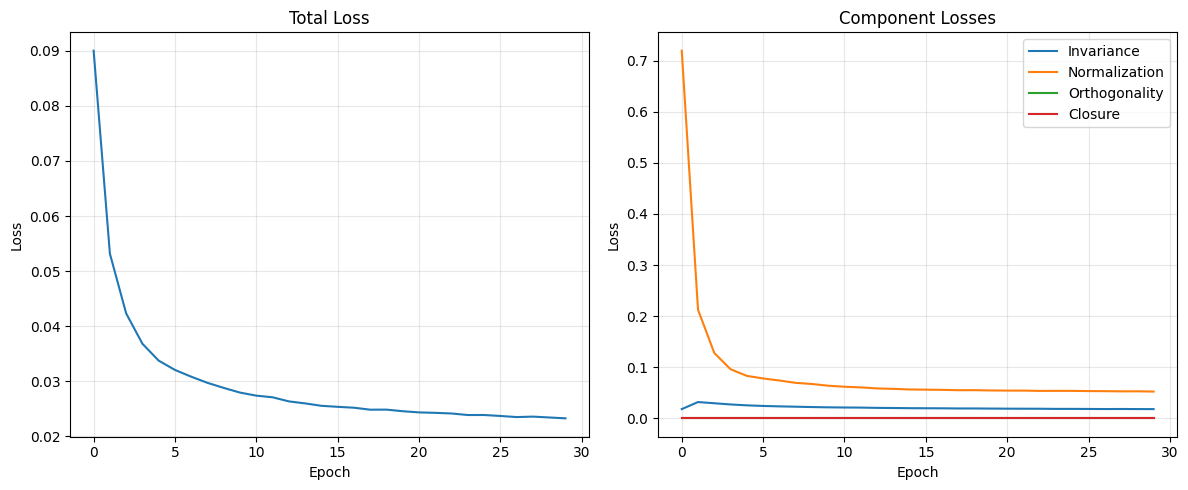

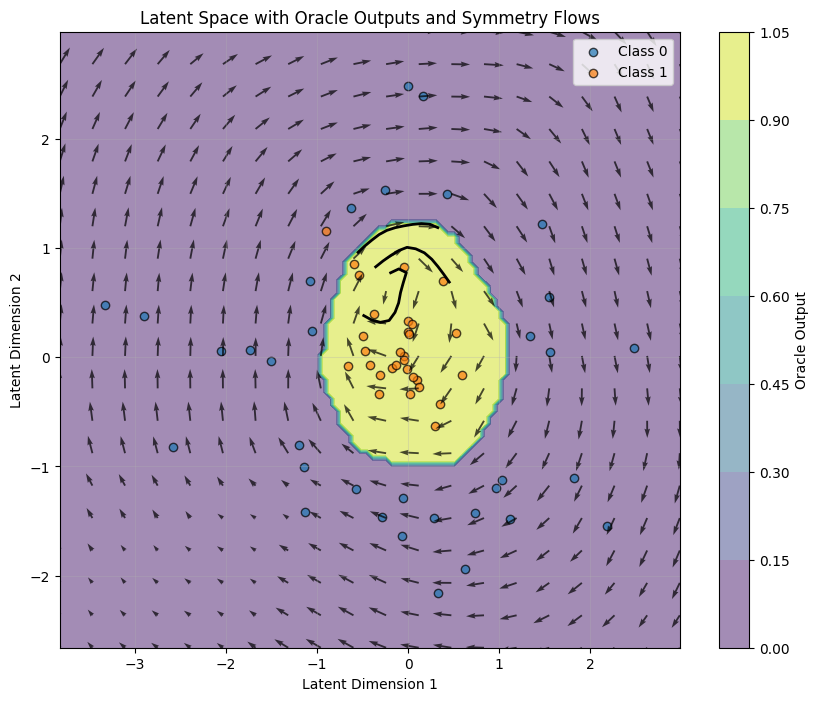

Visualizing decoded images along symmetry flow...


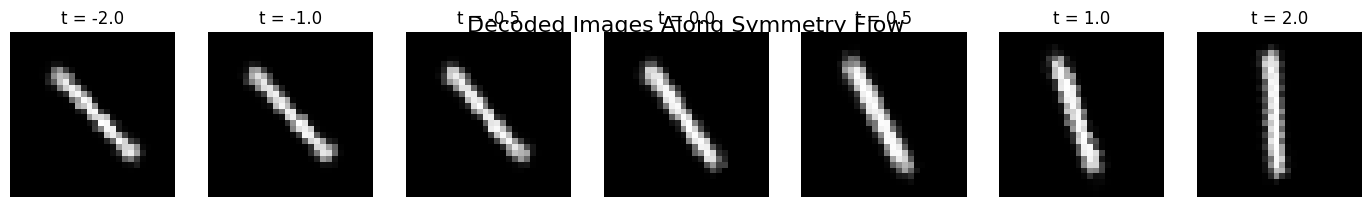

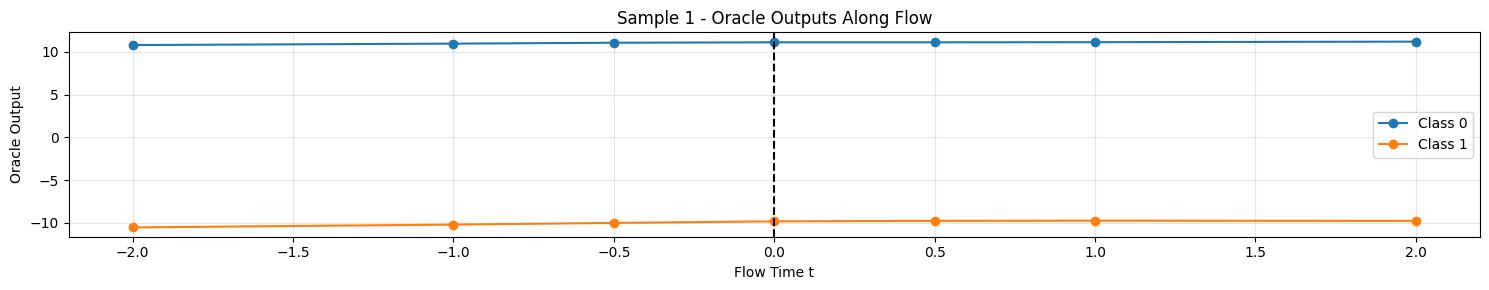

Single-generator symmetry model saved to symmetry_model_1gen.pth
Training 2 symmetry generators...
Epoch 1/30 - Loss: 0.1705 - Inv: 0.0128 - Norm: 1.3412 - Ortho: 0.0230 - Closure: 0.0054
Epoch 2/30 - Loss: 0.1576 - Inv: 0.0162 - Norm: 1.1793 - Ortho: 0.0221 - Closure: 0.0140
Epoch 3/30 - Loss: 0.1413 - Inv: 0.0320 - Norm: 0.8981 - Ortho: 0.0155 - Closure: 0.0393
Epoch 4/30 - Loss: 0.1223 - Inv: 0.0367 - Norm: 0.6847 - Ortho: 0.0095 - Closure: 0.0764
Epoch 5/30 - Loss: 0.1137 - Inv: 0.0367 - Norm: 0.6125 - Ortho: 0.0074 - Closure: 0.0834
Epoch 6/30 - Loss: 0.1091 - Inv: 0.0362 - Norm: 0.5705 - Ortho: 0.0072 - Closure: 0.0859
Epoch 7/30 - Loss: 0.1063 - Inv: 0.0359 - Norm: 0.5504 - Ortho: 0.0066 - Closure: 0.0879
Epoch 8/30 - Loss: 0.1040 - Inv: 0.0349 - Norm: 0.5356 - Ortho: 0.0064 - Closure: 0.0910
Epoch 9/30 - Loss: 0.1029 - Inv: 0.0350 - Norm: 0.5289 - Ortho: 0.0063 - Closure: 0.0879
Epoch 10/30 - Loss: 0.1009 - Inv: 0.0341 - Norm: 0.5145 - Ortho: 0.0062 - Closure: 0.0919
Epoch 11/3

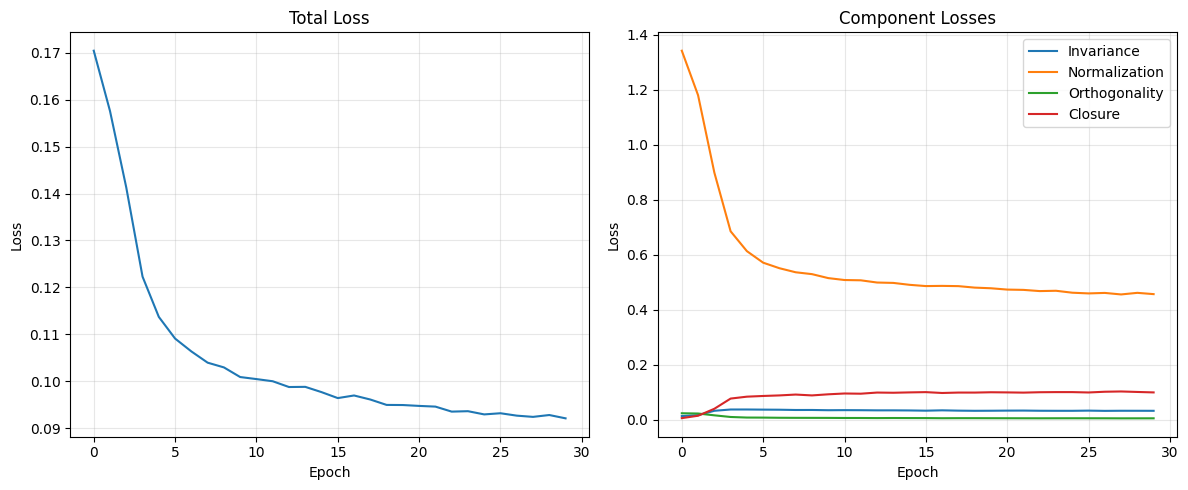

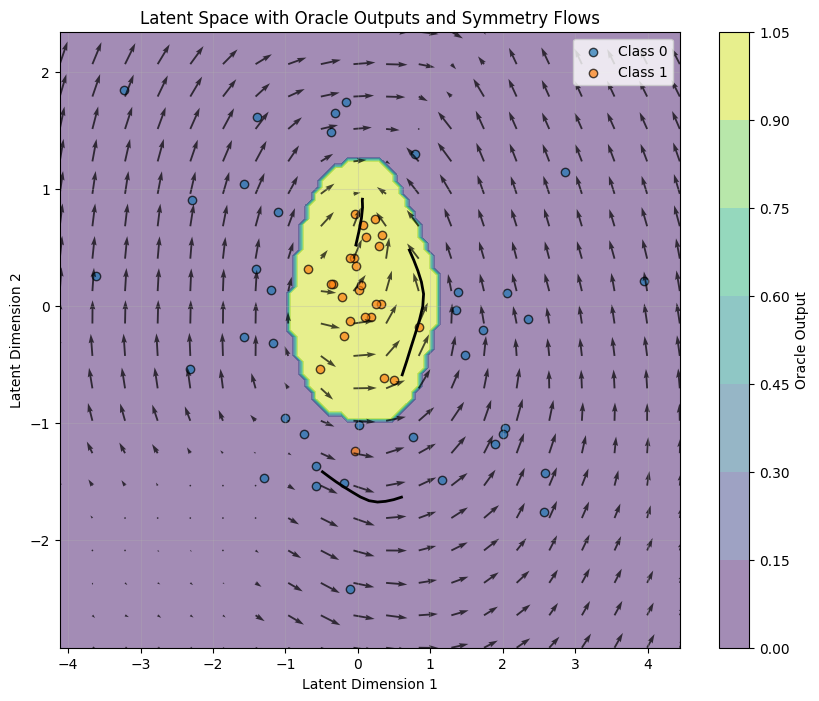

Visualizing effect of each generator...
Generator 1:


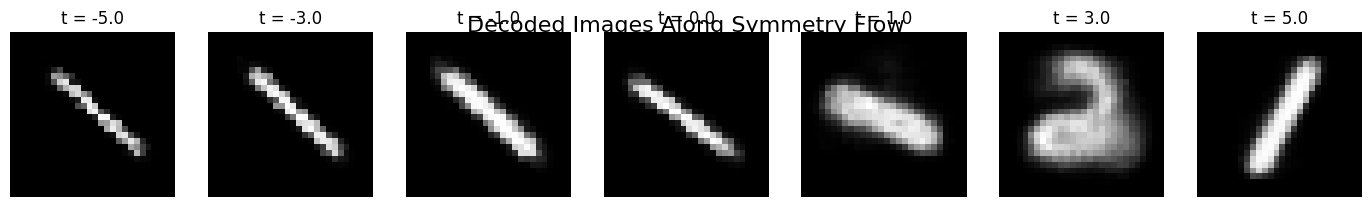

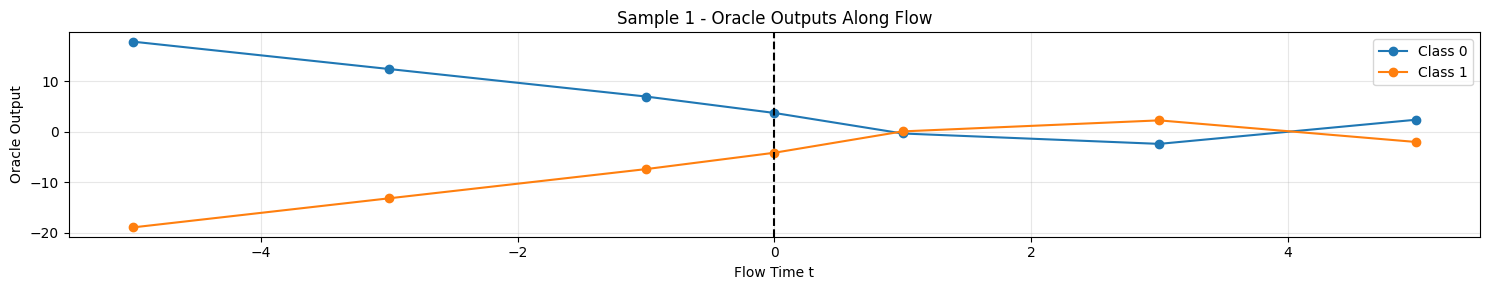

Generator 2:


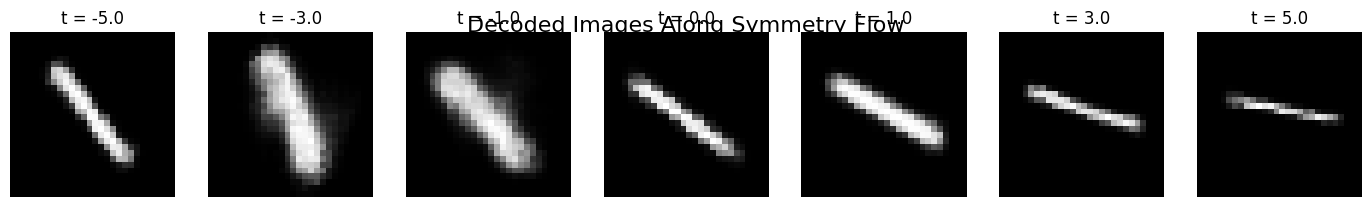

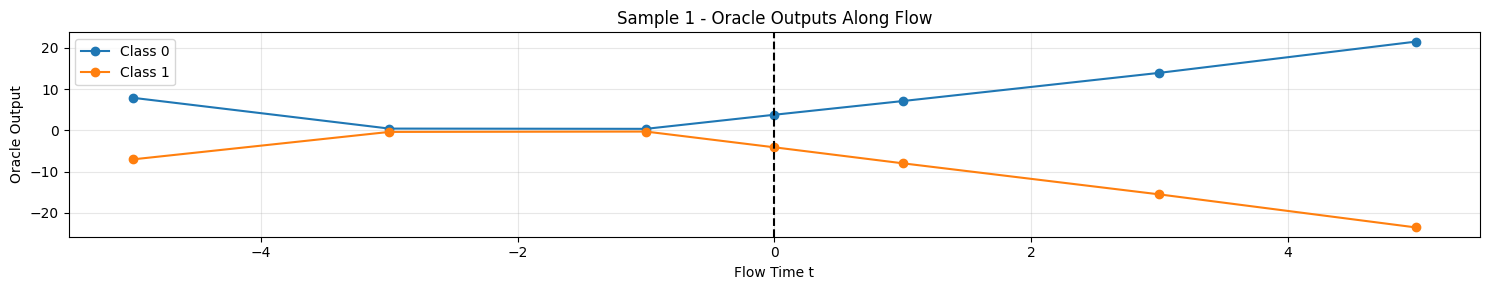

Comparing all generators...


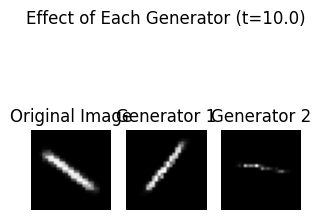

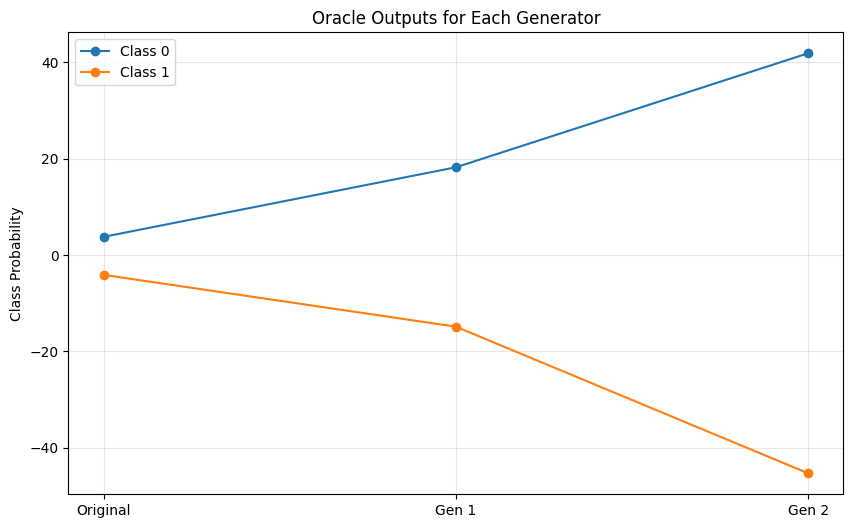

Two-generator symmetry model saved to symmetry_model_2gen.pth


In [2]:
# Example usage
if __name__ == "__main__":
    # File path
    file_path = "/kaggle/input/e2e-specific-task-1-dataset/rotated_digits.hdf5"
    
    # Paths to pre-trained models
    vae_model_path = '/kaggle/input/deep-2/vae_model.pth'
    classifier_model_path = '/kaggle/input/deep-2-classifier/classifier_model.pth'
    
    # Set random seed for reproducibility
    set_seed()
    
    # Load pre-trained VAE model
    print("Loading pre-trained VAE model...")
    vae_model = load_model("deep", latent_dim=2, path=vae_model_path)
    vae_model.to(device)
    
    # Load pre-trained classifier model
    print("Loading pre-trained classifier model...")
    num_classes = 2  # Adjust based on your data
    classifier_model = load_classifier(latent_dim=2, num_classes=num_classes, path=classifier_model_path)
    classifier_model.to(device)
    
    # Load data
    print("Loading data...")
    data = load_data(file_path, digits=['digit_1', 'digit_2'])
    
    # Prepare data for classifier
    print("Preparing data...")
    train_loader, test_loader = prepare_classification_data(data, batch_size=64)
    
    # Create latent dataset
    print("Encoding data to latent distributions...")
    mu_train, log_var_train, y_train = encode_dataset(vae_model, train_loader)
    
    # Create dataset of latent distributions
    latent_dataset = TensorDataset(mu_train, log_var_train, y_train)
    latent_loader = DataLoader(latent_dataset, batch_size=64, shuffle=True)
    
    # Discover symmetries with a single generator first
    symmetry_model_1, _, history_1 = discover_symmetries(
        vae_model, classifier_model, latent_loader,
        num_generators=1,
        epochs=30,
        lr=1e-3,
        epsilon=0.1,
        hidden_dim=128,
        device=device
    )
    
    # # Save the trained symmetry model
    torch.save(symmetry_model_1.state_dict(), 'symmetry_model_1gen.pth')
    print("Single-generator symmetry model saved to symmetry_model_1gen.pth")
    
    # Try with multiple generators
    symmetry_model_2, structure_constants, history_2 = discover_symmetries(
        vae_model, classifier_model, latent_loader,
        num_generators=2,  # Try with 2 generators
        epochs=30,
        lr=1e-3,
        epsilon=0.1,
        hidden_dim=128,
        device=device
    )
    
    # Save the trained multi-generator symmetry model
    torch.save({
        'model_state_dict': symmetry_model_2.state_dict(),
        'structure_constants': structure_constants if structure_constants is not None else None
    }, 'symmetry_model_2gen.pth')
    print("Two-generator symmetry model saved to symmetry_model_2gen.pth")